 # Dynamics of a Single-Neuron Linear Network
 This notebook generates Figures 2, 3, and 4 in the main text and Figures 7 and 8 in Appendix A for the exact dynamics of a single-neuron model.

## Setup Functions
The following cells define plotting functions, setup the loss/gradient, and generate theory predictions.

In [1]:
import os

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy.integrate import solve_ivp

### Plotting

In [2]:
# Plot styles
def style_3D(ax, lims=None, no_axes=False, nogrid=False, nofill=False):

    # Boundary
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(3)

    # Customize ticks and axes
    ax.tick_params(axis='both', which='major', length=10, width=1.5, pad=10, labelsize=15)
    ax.tick_params(axis='both', which='minor', width=1, length=2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.zaxis.set_major_locator(plt.MaxNLocator(4))
    ax.zaxis._axinfo['juggled'] = (1,2,0)

    if lims is not None:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_zlim(lims)

    if no_axes:
        ax.set_axis_off()

    if nogrid:
        ax.grid(False)

    if nofill:
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False


# Plot styles
def style_heatmaps(ax, xlabels=True, ylabels=True, xlim=None, ylim=None):
    if xlabels:
        ax.tick_params(axis="x", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True, direction='out',length=7,width=1.5,pad=0,
                       labelsize=24,labelrotation=45)
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    else:
        ax.tick_params(axis="x", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True, direction='out',length=7,width=1.5,pad=0,
                       labelsize=24,labelrotation=45)
        ax.set_xlabel("")
    if ylabels:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=4,
                   labelsize=24)
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    else:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=False, left=True, right=False,
                   labelleft=False, direction='out',length=7,width=1.5,pad=4,
                   labelsize=24)
        ax.set_ylabel("")
    ax.xaxis.offsetText.set_fontsize(20)

    # Boundary
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

    # Limits
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

def style_axes(ax, numyticks=5, numxticks=5):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=24)
    ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))

    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=24)
    ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))
    #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.ticklabel_format(axis="x", useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

In [3]:
def plot_loss(ax, lim1, lim2, XX, XY):

    b1 = np.linspace(1.1 * lim1[0], 1.1 * lim1[1], 100)
    b2 = np.linspace(1.1 * lim2[0], 1.1 * lim2[1], 100)

    b1, b2 = np.meshgrid(b1, b2)
    loss = XX[0,0]*b1**2 + XX[1,1]*b2**2 + 2 * XX[0,1]*b1*b2 - 2*XY[0]*b1 - 2*XY[1]*b2
    loss += np.abs(loss.min())

    zmin, zmax = loss.min(), loss.max()
    cnorm = colors.Normalize(vmin=zmin, vmax=zmax)

    mesh = ax.contourf(b1, b2, loss, levels=np.linspace(zmin, zmax, 20), cmap='RdBu', norm=cnorm)
    ax.contour(b1, b2, loss, levels=np.linspace(zmin, zmax, 20), colors='k')

In [4]:
def plot_minima_surface(ax, OLS, lim, color="red", opacity=0.9):

    null_direction = np.array([-OLS[1], OLS[0]]) / np.linalg.norm(OLS)

    xx = np.linspace(1e-1, 10, 500)
    yy = np.linspace(-10, 10, 500)
    xx, yy = np.meshgrid(xx, yy)
    w1 = xx * OLS[0] + yy * null_direction[0]
    w2 = xx * OLS[1] + yy * null_direction[1]
    a = 1 / xx

    # Filter data within plot limits
    mask = ((w1 >= lim[0]) & (w1 <= lim[1]) &
            (w2 >= lim[0]) & (w2 <= lim[1]) &
            (a >= lim[0]) & (a <= lim[1]))
    w1_trim = np.ma.masked_where(~mask, w1)
    w2_trim = np.ma.masked_where(~mask, w2)
    a_trim = np.ma.masked_where(~mask, a)

    # Plot the hyperbolic surface
    ax.plot_surface(w1_trim, w2_trim, a_trim, color=color, alpha=opacity, zorder=0)
    ax.plot_surface(-w1_trim, -w2_trim, -a_trim, color=color, alpha=opacity, zorder=0)

In [5]:
def plot_task_aligned_surface(R, ax, lim, XX, XY, opacity=1.0):
    OLS = np.linalg.pinv(XX) @ XY
    OLS /= np.linalg.norm(OLS)

    a = np.linspace(-lim, lim, 500)
    w = np.linspace(-lim, lim, 500)
    a, w = np.meshgrid(a, w)

    x = w * OLS[0]
    y = w * OLS[1]
    z = a

    loss = MSE(z * x, z * y, XX, XY)
    cnorm = colors.LogNorm(vmin=np.min(loss), vmax=np.max(loss))
    ax.plot_surface(x, y, z, facecolors=cm.RdBu(cnorm(loss)), alpha=opacity, shade=False, edgecolor='none', zorder=0)
    surf = cm.ScalarMappable(norm=cnorm, cmap="RdBu")
    return surf

In [6]:
def plot_conserved_surface(R, ax, lim, XX, XY, opacity=1.0):
    num = 100
    # R = a^2 - |w|^2
    if R > 0:

        alpha = np.linspace(0, lim, num)
        theta = np.linspace(0, 2*np.pi, num)
        alpha, theta = np.meshgrid(alpha, theta)

        x = alpha * np.cos(theta)
        y = alpha * np.sin(theta)
        z = np.sqrt(alpha**2 + R)

        loss = MSE(z * x, z * y, XX, XY)
        cnorm = colors.LogNorm(vmin=np.min(loss), vmax=np.max(loss))
        ax.plot_surface(x, y, z, facecolors=cm.RdBu(cnorm(loss)), alpha=opacity, shade=False, edgecolor='none', zorder=0)

        loss = MSE(-z * x, -z * y, XX, XY)
        cnorm = colors.LogNorm(vmin=np.min(loss), vmax=np.max(loss))
        ax.plot_surface(x, y, -z, facecolors=cm.RdBu(cnorm(loss)), alpha=opacity, shade=False, edgecolor='none', zorder=0)
        surf = cm.ScalarMappable(norm=cnorm, cmap="RdBu")
    else:
        alpha = np.linspace(-lim, lim, num)
        theta = np.linspace(0, 2*np.pi, num)
        alpha, theta = np.meshgrid(alpha, theta)

        x = np.sqrt(alpha**2 - R) * np.cos(theta)
        y = np.sqrt(alpha**2 - R) * np.sin(theta)
        z = alpha

        loss = MSE(z * x, z * y, XX, XY)
        cnorm = colors.LogNorm(vmin=np.min(loss), vmax=np.max(loss))
        ax.plot_surface(x, y, z, facecolors=cm.RdBu(cnorm(loss)), alpha=opacity, shade=False, edgecolor='none', zorder=0)
        surf = cm.ScalarMappable(norm=cnorm, cmap="RdBu")
    return surf

In [7]:
def plot_basin_seperating_surface(ax, lims, XX, XY, opacity=1.0):
    num = 100
    delta = np.linspace(-2 * lims[1]**2, -1e-8, num)
    alpha = np.linspace(lims[0], lims[1], num)
    alpha, delta = np.meshgrid(alpha, delta)

    OLS = np.linalg.pinv(XX) @ XY

    k = alpha * (-delta / 2 - np.sqrt(delta**2 + 4 * np.linalg.norm(OLS)**2) / 2)

    a = OLS[0]**2 / OLS[1]**2 + 1
    b = -2*k*OLS[0]/OLS[1]**2
    c = k**2 / OLS[1]**2 + delta - alpha**2

    x = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    y = (k - OLS[0]*x) / OLS[1]
    z = alpha

    # Filter data within plot limits
    mask = ((x >= lims[0]) & (x <= lims[1]) &
            (y >= lims[0]) & (y <= lims[1]) &
            (z >= lims[0]) & (z <= lims[1]))

    x_trimmed = np.ma.masked_where(~mask, x)
    y_trimmed = np.ma.masked_where(~mask, y)
    z_trimmed = np.ma.masked_where(~mask, z)


    loss = MSE(z * x, z * y, XX, XY)
    cnorm = colors.LogNorm(vmin=np.min(loss), vmax=np.max(loss))
    ax.plot_surface(x_trimmed, y_trimmed, z_trimmed, facecolors=cm.RdBu(cnorm(loss)), alpha=opacity, shade=False, edgecolor='none', zorder=0)
    surf = cm.ScalarMappable(norm=cnorm, cmap="RdBu")


    x = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    y = (k - OLS[0]*x) / OLS[1]
    z = alpha

    # Filter data within plot limits
    mask = ((x >= lims[0]) & (x <= lims[1]) &
            (y >= lims[0]) & (y <= lims[1]) &
            (z >= lims[0]) & (z <= lims[1]))

    x_trimmed = np.ma.masked_where(~mask, x)
    y_trimmed = np.ma.masked_where(~mask, y)
    z_trimmed = np.ma.masked_where(~mask, z)

    loss = MSE(z * x, z * y, XX, XY)
    cnorm = colors.LogNorm(vmin=np.min(loss), vmax=np.max(loss))
    ax.plot_surface(x_trimmed, y_trimmed, z_trimmed, facecolors=cm.RdBu(cnorm(loss)), alpha=opacity, shade=False, edgecolor='none', zorder=0)
    surf = cm.ScalarMappable(norm=cnorm, cmap="RdBu")

    return surf

In [8]:
def plot_trimmed(ax, x, y, z, lim, lw, color, zorder, ls='-'):

    if len(lim) == 2:
        xlim = lim
        ylim = lim
        zlim = lim
    else:
        xlim = lim[0]
        ylim = lim[1]
        zlim = lim[2]


    if z is not None:
        # Filter data within plot limits
        mask = ((x >= xlim[0]) & (x <= xlim[1]) &
                (y >= ylim[0]) & (y <= ylim[1]) &
                (z >= zlim[0]) & (z <= zlim[1]))
        x_trimmed = x[mask]
        y_trimmed = y[mask]
        z_trimmed = z[mask]

        ax.plot(x_trimmed, y_trimmed, z_trimmed, lw=lw, ls=ls, color=color, zorder=zorder)
    else:
        # Filter data within plot limits
        mask = ((x >= xlim[0]) & (x <= xlim[1]) &
                (y >= ylim[0]) & (y <= ylim[1]))
        x_trimmed = x[mask]
        y_trimmed = y[mask]

        ax.plot(x_trimmed, y_trimmed, lw=lw, ls=ls, color=color, zorder=zorder)


In [9]:
def get_diverging_colors_7(index):
    colors = [
        "#964b00",
        "#a47e1d",
        "#acaf4d",
        "#b0df89",
        "#71c28b",
        "#39a189",
        "#008080"
    ]
    return colors[index]

### Loss and Gradient

In [10]:
def MSE(b1, b2, XX, XY, eps=1e-2):
    loss = XX[0,0]*b1**2 + XX[1,1]*b2**2 + 2 * XX[0,1]*b1*b2 - 2*XY[0]*b1 - 2*XY[1]*b2
    return loss - np.min(loss) + eps

In [11]:
def get_gradient(XX, XY):
    def grad(theta):
        w = theta[:-1]
        a = theta[-1]
        beta = a * w
        residual = XX.dot(beta) - XY
        dw = a * residual
        da = w.dot(residual)
        dtheta = np.concatenate((dw, [da]))
        return dtheta
    return lambda t, theta : -grad(theta)

In [12]:
def kernel_distance(a0, w0, a_t, w1_t, w2_t):
    numer = 0
    numer += 2*a0**2 * a_t**2
    numer += a0**2 * (w1_t**2 + w2_t**2)
    numer += a_t**2 * np.linalg.norm(w0)**2
    numer += (w0[0]*w1_t + w0[1]*w2_t)**2
    denom1 = np.sqrt(2*a0**4 + 2*a0**2*np.linalg.norm(w0)**2 + np.linalg.norm(w0)**4)
    denom2 = np.sqrt(2*a_t**4 + 2*a0**2*(w1_t**2 + w2_t**2) + (w1_t**2 + w2_t**2)**2)
    denom = denom1 * denom2
    S = 1 - numer / denom
    return S

### Theory

In [13]:
def coordinates(R, beta):
    """
    Takes in an R = a^2 - |w|^2 and a beta = aw and returns a,w
    Note: This only works for positive a.
    """
    a = np.array([np.sqrt((R + np.sqrt(R**2 + 4*np.linalg.norm(beta)**2))/2)])
    w = beta / a
    return w, a

In [14]:
def balanced_theory(R, time, w0, a0, XY):

    nu0 = a0 * np.linalg.norm(w0)
    mu0 = np.dot(w0, XY) / (np.linalg.norm(w0) * np.linalg.norm(XY))
    beta0 = a0 * w0

    r = np.linalg.norm(XY)
    y0 = mu0 * r
    c1 = np.arctanh(y0 / r) / r
    scale = c1*r + r * time
    alignment_theory = r * np.tanh(scale) / r

    norm0 = nu0
    numer = r * (np.cosh(2 * scale) + 1)
    denom = 2 * scale + np.sinh(2 * scale)
    c2 = (numer[0] - norm0 * denom[0]) / (norm0 * r)
    norm_theory = numer / (denom + c2 * r)

    dir1_0 = beta0[0] / norm0
    dir2_0 = beta0[1] / norm0
    c3 = (dir1_0 - XY[0] * np.tanh(c1 * r) / r) * np.cosh(c1 * r)
    c4 = (dir2_0 - XY[1] * np.tanh(c1 * r) / r) * np.cosh(c1 * r)
    beta1_theory = (c3/np.cosh(scale) + XY[0] * np.tanh(scale) / r) * norm_theory
    beta2_theory = (c4/np.cosh(scale) + XY[1] * np.tanh(scale) / r) * norm_theory

    abs_a = (norm_theory**2)**(1/4)
    sign_a = np.sign(a0)
    a_theory = sign_a * abs_a
    w1_theory = beta1_theory / a_theory
    w2_theory = beta2_theory / a_theory

    return w1_theory, w2_theory, a_theory

In [15]:
def theory(R, time, w, a, OLS):
    # Being anal about some things
    assert a > 0, "For initialization always choosing positive a"
    if R > 0:
        assert (w**2).sum() < a**2
        # tanh_theta0 = np.linalg.norm(w) / a
        # # nice expression for cosh(arctanh(_))
        # phi0 = 1 / np.sqrt(1 - tanh_theta0**2)
        phi0 = np.cosh(np.arctanh(np.linalg.norm(w) / a))
    elif R < 0:
        assert (w**2).sum() > a**2
        # tanh_theta0 = a / np.linalg.norm(w)
        # phi0 = tanh_theta0 / np.sqrt(1 - tanh_theta0**2)
        phi0 = np.sinh(np.arctanh(a / np.linalg.norm(w)))
    else:
        # FIXME: handle R=0
        raise ValueError(f"Not supporting R={R}")
        assert (w**2).sum() == a**2
        tanh_theta0 = 1

    s = np.linalg.norm(OLS)

    # Initial values
    nu0 = (w / a).dot(OLS)

    print(f"R: {R}, s: {s}, nu0: {nu0}, phi0: {phi0}")

    # Quantity that comes up a lot, complex-valued
    Q = 1/2 * time * np.sqrt(4*s**2 + R**2) + np.arctanh((R + 2*nu0) / np.sqrt(4*s**2 + R**2) + 0j)

    # Compute nu(t)
    tanh_Q = np.tanh(Q)
    assert all(abs(tanh_Q.imag) < 1e-7), "Imaginary part should be vanishing for nu quantity"
    nu = 1/2 * (-R + np.sqrt(4*s**2 + R**2) * tanh_Q.real)

    # This expression comes from using F[_] for nu. One expression for positive R, the other one
    # for negative. Choosing positive sign for each (which might just be working because with our
    # setup a_0 is always positive so that \phi_0 is always positive)
    if R < 0:
        term_in_sqrt = \
     (1 / np.cosh(Q))**2 * \
      (4*s**2 * (s**2 - nu0*(R+nu0)) * phi0**2 - \
       (4*s**2 + R**2) * (s**2 + (s-nu0)*(s+nu0)*phi0**2) * np.exp(-time * R) + \
       R * (-s**2 + nu0*(R+nu0)) * phi0**2 * \
            (R * np.cosh(2 * Q) - np.sqrt(4*s**2 + R**2) * np.sinh(2 * Q))) / ((s**2 - nu0*(R+nu0)) * phi0**2)
        phi = 2 * s / np.sqrt(term_in_sqrt) * 1j
        assert all(abs(phi.imag) < 1e-7), "Imaginary part should be vanishing"
    else:
        term_in_sqrt = \
     (1 / np.cosh(Q))**2 * \
      (4*s**2 * (s**2 - nu0*(R+nu0)) * phi0**2 - \
       (4*s**2 + R**2) * (-nu0**2*phi0**2 + s**2*(-1+phi0**2)) * np.exp(-time * R) + \
       R * (-s**2 + nu0*(R+nu0)) * phi0**2 * \
            (R * np.cosh(2 * Q) - np.sqrt(4*s**2 + R**2) * np.sinh(2 * Q))) / ((s**2 - nu0*(R+nu0)) * phi0**2)
        assert all(abs(term_in_sqrt.imag) < 1e-7), "Imaginary part should be vanishing"
        phi = 2 * s / np.sqrt(term_in_sqrt)

    # assert all(abs(phi.imag) < 1e-7), f"Imaginary part should be vanishing, it's: {phi}"

    # Can now recover theta
    if R > 0:
        # When R > 0, we know that a does not change sign. This means that theta does not change
        # sign, and in particular, since we're always starting with positive a, theta starts
        # positive and remains positive. This is fine here because arccosh gives the inverse as
        # positive (cosh is technically not invertible)
        theta = np.arccosh(phi)

        # FIXME: technically assumes $\|beta_*\|=0$
        mu = 1 / np.tanh(theta) * nu
    elif R < 0:
        # This theta should be able to change sign
        theta = np.arcsinh(phi)
        mu = np.tanh(theta) * nu

    # This is \nu in paper
    signed_beta_norm = np.abs(R) * np.sinh(2 * theta) / 2

    return nu, phi, theta, signed_beta_norm, mu


def a_w_norm(R, theta):
    if R > 0:
        # |a| is larger than ||w||, \tan(\theta)=||w||/a
        a = np.sqrt(R) * np.cosh(theta)
        w_norm = np.sqrt(R) * np.sinh(theta)
    elif R < 0:
        a = np.sqrt(-R) * np.sinh(theta)
        w_norm = np.sqrt(-R) * np.cosh(theta)
    return a, w_norm


def get_w_theory(w0, w_norm, beta_star, mu, R, theta):

    d = len(w0)
    beta_hat = beta_star / np.linalg.norm(beta_star)
    w0_hat = w0 / np.linalg.norm(w0)

    # We get the components of w in the basis (\beta_*, (I-\beta_*\beta_*^T)w_0)

    # this `mu` is <w^, b> (has not normalized by beta norm)
    c2 = mu / np.linalg.norm(beta_star)

    if (w0_hat.dot(beta_hat)**2 >= (1 - 1e-9)) and (w0_hat.dot(beta_hat)**2 <= (1 + 1e-9)):
        return (c2[None, :] * beta_hat[:, None] * w_norm).T

    # Always taking positive square root. This is maybe wrong.
    c1 = np.sqrt(1 - c2**2)

    proj = (np.eye(d) - (beta_hat[:, None] @ beta_hat[:, None].T)) / np.sqrt(1 - (beta_hat.dot(w0_hat))**2)

    w_hat =  c1[None, :] * (proj @ w0_hat)[:, None] + c2[None, :] * beta_hat[:, None]

    # (d, T), (T,)
    print(w_hat.shape, w_norm.shape)

    return (w_hat * w_norm).T

In [16]:
# Gradient of q(x) assuming x is positive
def grad_q(delta, x):
    return 3/2 * np.sqrt(np.sqrt(x**2 + delta**2 / 4) - delta/2)

# Define the vector z
def z_vector(delta, beta0):
    norm = np.linalg.norm(beta0)
    return -3/2 * np.sqrt(np.sqrt(norm**2 + delta**2/4) - delta/2) * beta0 / norm

# Return alpha that determines interpolating solution
def implicit_bias_theory(delta, beta0, OLS):

    # Define null direction
    null = np.array([-OLS[1], OLS[0]])
    null /= np.linalg.norm(null)

    # Define c and k
    c = np.linalg.norm(OLS)
    k = -2 * z_vector(delta, beta0).dot(null) / 3

    # Define alpha
    kappa = (k**2 + delta) / 2
    alpha = k * np.sqrt(kappa + np.sqrt(kappa**2 + c**2))

    return alpha

Sort out what's going wrong in edge cases (e.g. other OLS soln)

## Figures 2, 3, and 4(a)

R: -4, s: 1.0, nu0: 0.0, phi0: [0.24293414]
(2, 70) (70,)
R: -2, s: 1.0, nu0: 0.0, phi0: [0.45508986]
(2, 52) (52,)
R: -1, s: 1.0, nu0: 0.0, phi0: [0.78615138]
(2, 39) (39,)


/Users/allanraventos/miniconda3/envs/getrichquick/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/allanraventos/miniconda3/envs/getrichquick/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


R: 1, s: 1.0, nu0: 0.0, phi0: [1.27201965]
(2, 32) (32,)
R: 2, s: 1.0, nu0: 0.0, phi0: [1.09868411]
(2, 35) (35,)
R: 4, s: 1.0, nu0: 0.0, phi0: [1.02908551]
(2, 45) (45,)


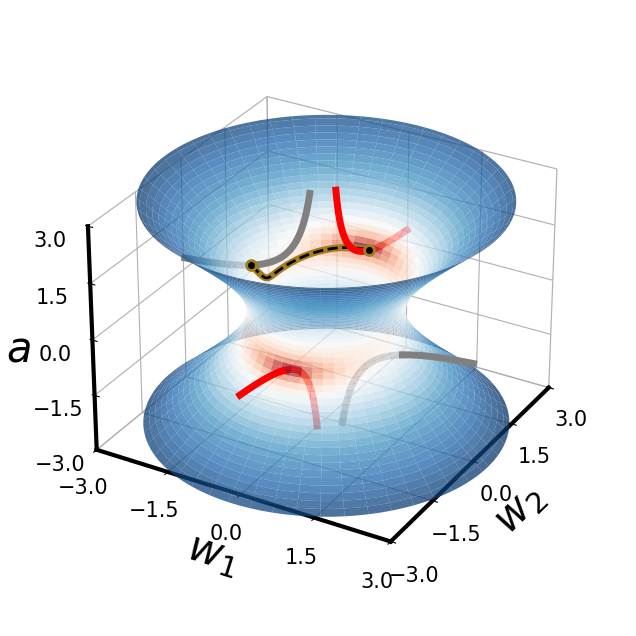

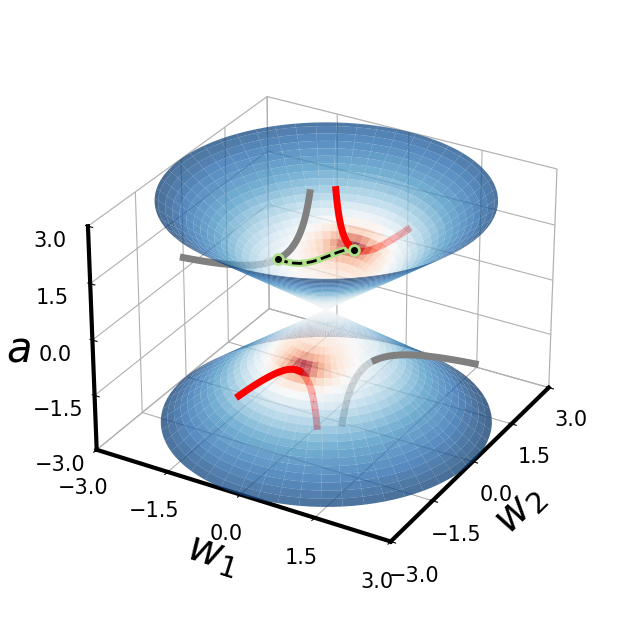

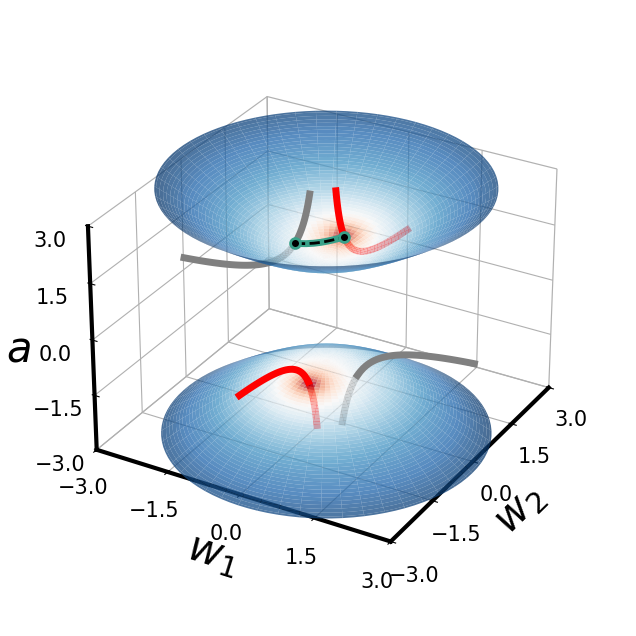

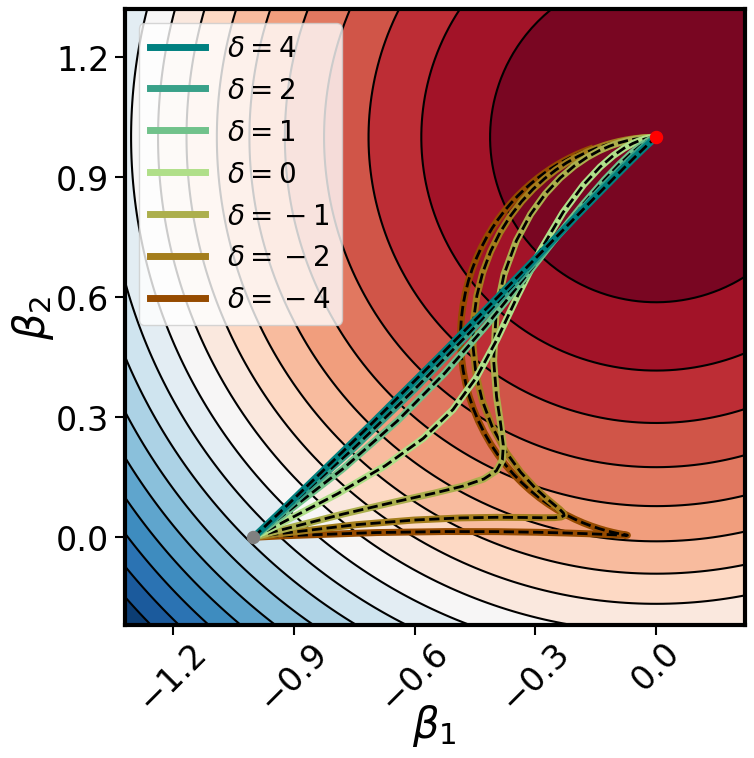

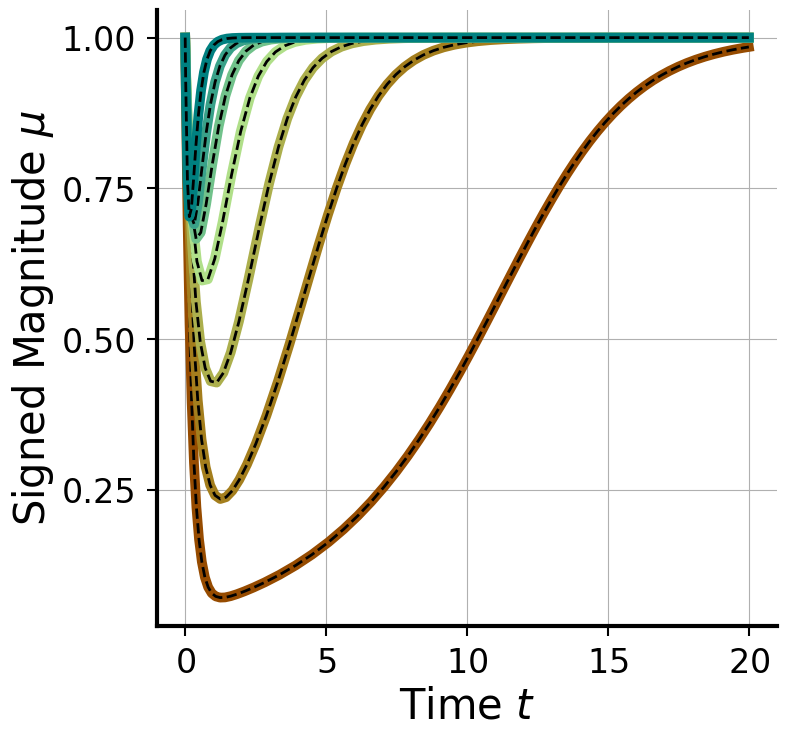

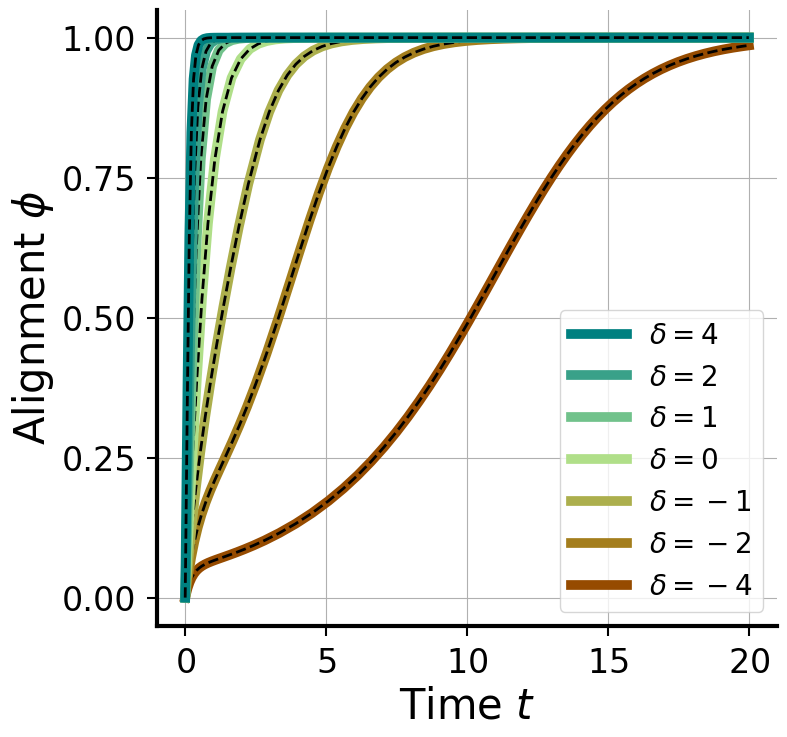

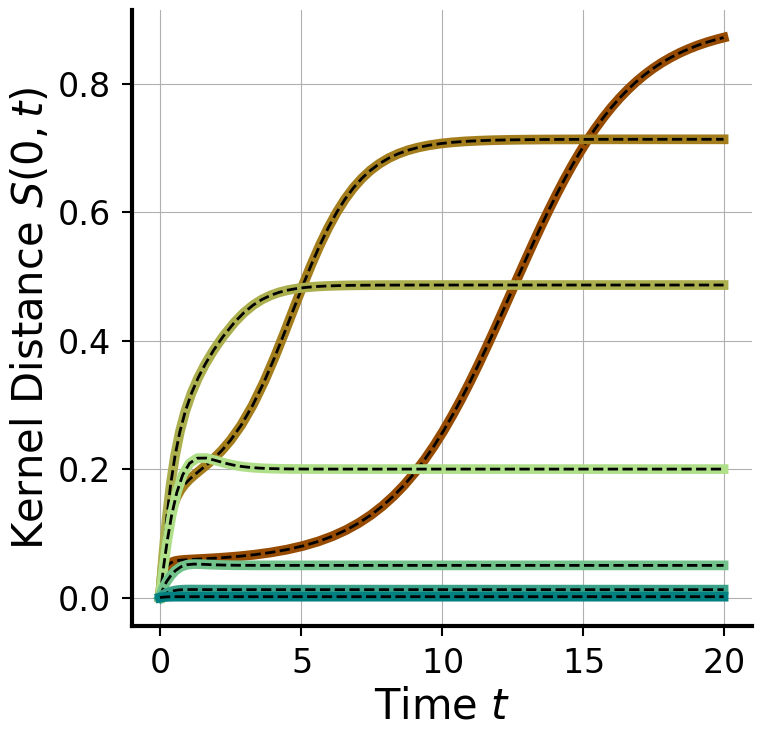

/Users/allanraventos/miniconda3/envs/getrichquick/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [17]:
# Create figures
fig1 = plt.figure(figsize=(8, 8))
fig2 = plt.figure(figsize=(8, 8))
fig3 = plt.figure(figsize=(8, 8))
fig4 = plt.figure(figsize=(8, 8))
fig5 = plt.figure(figsize=(8, 8))
fig6 = plt.figure(figsize=(8, 8))
fig7 = plt.figure(figsize=(8, 8))

# Create axes
ax1 = fig1.add_subplot(111, projection='3d', computed_zorder=False)  # First plot is a 3D plot
ax2 = fig2.add_subplot(111, projection='3d', computed_zorder=False)  # Second plot is a 3D plot
ax3 = fig3.add_subplot(111, projection='3d', computed_zorder=False)  # Third plot is a 3D plot
ax4 = fig4.add_subplot(111)  # Fourth plot is a 2D plot
ax5 = fig5.add_subplot(111)  # Fifth plot is a 2D plot
ax6 = fig6.add_subplot(111)  # Sixth plot is a 2D plot
ax7 = fig7.add_subplot(111)  # Seventh plot is a 2D plot
axes = [ax1, ax2, ax3]

# Hyperparameters
lims = (-3, 3)
R_values = [-4, -2, -1, 0, 1, 2, 4] # a^2 - |w|^2
R_3D_plot = [-2, 0, 2]

# Setup Data
XX = np.eye(2)
XY = np.array([0.0, 1.0])

# OLS solution
# (NOTE: this is the least-norm solution, but to be specific it is the only solution
# since we are taking X^TX to be full-rank, i.e. X to be full-rank)
OLS = np.linalg.pinv(XX) @ XY
ax4.scatter(OLS[0], OLS[1], s=75, c='red', zorder=3)

# Initialization
alpha=1.0
w0 = np.array([-1.0, 0.0])
w0 /= np.linalg.norm(w0)
a0 = np.array([1.0])
w0 *= alpha
a0 *= alpha
beta0 = a0 * w0
ax4.scatter(beta0[0], beta0[1], s=75, c='grey', zorder=3)

# Plot Function Space Surface (make `eps` of room along each axis past OLS or beta0)
eps = 0.2
lim1 = np.array([min(OLS[0], beta0[0]) - eps, max(OLS[0], beta0[0]) + eps])
lim2 = np.array([min(OLS[1], beta0[1]) - eps, max(OLS[1], beta0[1]) + eps])
plot_loss(ax4, lim1, lim2, XX, XY)

i = 0
for j, R in enumerate(R_values):

    # Get color
    c = get_diverging_colors_7(j) 
    # c = cm.BrBG(j/6) #c = cm.tab10(j)

    # Initialization (NOTE: this is always setting a to be positive, adding assert)
    w, a = coordinates(R, beta0)
    assert a > 0
    theta0 = np.concatenate((w, a))

    # Gradient Flow
    T = 20
    grad = get_gradient(XX, XY)
    theta = solve_ivp(grad, [0, T], theta0, rtol=1e-6)
    time = theta.t
    w1_t = theta.y[0, :]
    w2_t = theta.y[1, :]
    a_t = theta.y[2, :]
    beta1 = a_t * w1_t
    beta2 = a_t * w2_t

    # Plot function space trajectories
    ax4.plot(beta1, beta2, c=c, lw=5, label=r'$\delta = {}$'.format(R))

    # Plot nu, mu, kernel distance
    nu = a_t * np.sqrt(w1_t**2 + w2_t**2)
    mu = (w1_t * OLS[0] + w2_t * OLS[1]) / (np.sqrt(w1_t**2 + w2_t**2) * np.linalg.norm(OLS))
    S = kernel_distance(a, w, a_t, w1_t, w2_t)
    ax5.plot(time, nu, c=c, lw=7, label=r'$\delta = {}$'.format(R))
    ax6.plot(time, mu, c=c, lw=7, label=r'$\delta = {}$'.format(R))
    ax7.plot(time, S, c=c, lw=7, label=r'$\delta = {}$'.format(R))

    # Plot theory
    if R == 0:
        w1_theory, w2_theory, a_theory = balanced_theory(R, time, w, a, OLS)
        signed_beta_norm_theory = a_theory * np.sqrt(w1_theory**2 + w2_theory**2)
        mu_theory = (w1_theory * OLS[0] + w2_theory * OLS[1]) / np.sqrt(w1_theory**2 + w2_theory**2)
    else:
        nu_theory, phi_theory, theta_theory, signed_beta_norm_theory, mu_theory = theory(R, time, w, a, OLS)
        a_theory, w_norm_theory = a_w_norm(R, theta_theory)
        w_theory = get_w_theory(w, w_norm_theory, OLS, mu_theory, R, None)
        w1_theory, w2_theory = w_theory[:, 0], w_theory[:, 1]
    if R in R_3D_plot:
      axes[i].plot(w1_theory, w2_theory, a_theory, lw=2, ls='--', color='k', zorder=1.5)
    beta1_theory = a_theory * w1_theory
    beta2_theory = a_theory * w2_theory
    ax4.plot(beta1_theory, beta2_theory, lw=2, ls='--', color='k')

    mu_theory /= np.linalg.norm(OLS)
    S_theory = kernel_distance(a, w, a_theory, w1_theory, w2_theory)
    ax5.plot(time, signed_beta_norm_theory, lw=2, ls='--', color='k')
    ax6.plot(time, mu_theory, lw=2, ls='--', color='k')
    ax7.plot(time, S_theory, lw=2, ls='--', color='k')

    if R in R_3D_plot:

        # Plot Conserved Quanitity over Parameter space
        surf = plot_conserved_surface(R, axes[i], lims[-1], XX, XY, opacity=0.75)
        # fig.colorbar(surf, ax=axes[i], pad=0.05, shrink=0.65, aspect=15)

        # Plot hyperbola of equivalent OLS solutions
        w_opt, a_opt = coordinates(R, OLS)
        t = np.linspace(1, 10, 100)
        plot_trimmed(axes[i], w_opt[0]/t, w_opt[1]/t, a_opt*t, lims, lw=5, color='red', zorder=2)
        plot_trimmed(axes[i], w_opt[0]*t, w_opt[1]*t, a_opt/t, lims, lw=5, color='red', zorder=-2)
        plot_trimmed(axes[i], -w_opt[0]*t, -w_opt[1]*t, -a_opt/t, lims, lw=5, color='red', zorder=2)
        plot_trimmed(axes[i], -w_opt[0]/t, -w_opt[1]/t, -a_opt*t, lims, lw=5, color='red', zorder=-2)

        # Initialization
        axes[i].scatter(w[0], w[1], a, color='k', s=50, edgecolor=c, linewidths=2, zorder=3)

        # Plot hyperbola of equivalent initializations
        t = np.linspace(1, 10, 100)
        plot_trimmed(axes[i], w[0]/t, w[1]/t, a*t, lims, lw=5, color='grey', zorder=2)
        plot_trimmed(axes[i], w[0]*t, w[1]*t, a/t, lims, lw=5, color='grey', zorder=-2)
        plot_trimmed(axes[i], -w[0]*t, -w[1]*t, -a/t, lims, lw=5, color='grey', zorder=2)
        plot_trimmed(axes[i], -w[0]/t, -w[1]/t, -a*t, lims, lw=5, color='grey', zorder=-2)

        # Plot parameter trajectories
        axes[i].plot(w1_t, w2_t, a_t, color=c, lw=5, zorder=1)
        axes[i].scatter(w1_t[-1], w2_t[-1], a_t[-1], color='k', s=50, edgecolor=c, linewidths=2, zorder=3)

        # Axes index
        i += 1


# Style plots
for ax in axes:
    style_3D(ax, lims=lims, nofill=True)
    ax.set_xlabel(r"$w_1$", labelpad=15, fontsize=30)
    ax.set_ylabel(r"$w_2$", labelpad=15, fontsize=30)
    ax.set_zlabel(r"$a$", labelpad=15, fontsize=30)
    ax.set_box_aspect(aspect=None, zoom=0.85)
    ax.view_init(elev=29) #azim=-60
style_heatmaps(ax4)
ax4.set_xlabel(r"$\beta_1$", labelpad=-10, fontsize=30)
ax4.set_ylabel(r"$\beta_2$", labelpad=0, fontsize=30)
ax4.legend(loc="best", fontsize=20, reverse=True)

style_axes(ax5)
style_axes(ax6)
style_axes(ax7)
ax5.set_xlabel(r"Time $t$", fontsize=30)
ax5.set_ylabel(r"Signed Magnitude $\mu$", fontsize=30)
ax6.set_xlabel(r"Time $t$", fontsize=30)
ax6.set_ylabel(r"Alignment $\phi$", fontsize=30)
ax7.set_xlabel(r"Time $t$", fontsize=30)
ax7.set_ylabel(r"Kernel Distance $S(0,t)$", fontsize=30)
ax6.legend(loc="best", fontsize=20, reverse=True)

# Show the plot
plt.show()

# Save figures
if not os.path.exists("unstructured"):
    os.makedirs("unstructured")
fig1.savefig('unstructured/negative.pdf', bbox_inches='tight')
fig2.savefig('unstructured/zero.pdf', bbox_inches='tight')
fig3.savefig('unstructured/positive.pdf', bbox_inches='tight')
fig4.savefig('unstructured/function-space.pdf', bbox_inches='tight')
fig5.savefig('unstructured/nu.pdf', bbox_inches='tight')
fig6.savefig('unstructured/mu.pdf', bbox_inches='tight')
fig7.savefig('unstructured/kernel-distance.pdf', bbox_inches='tight')

## Figure 4(b): $\beta$ dynamics in low-rank $X^\intercal X$ setting
Prior to Figure 4(b) we also incluse a visualization of the dynamics in parameter ($w, a$) space.

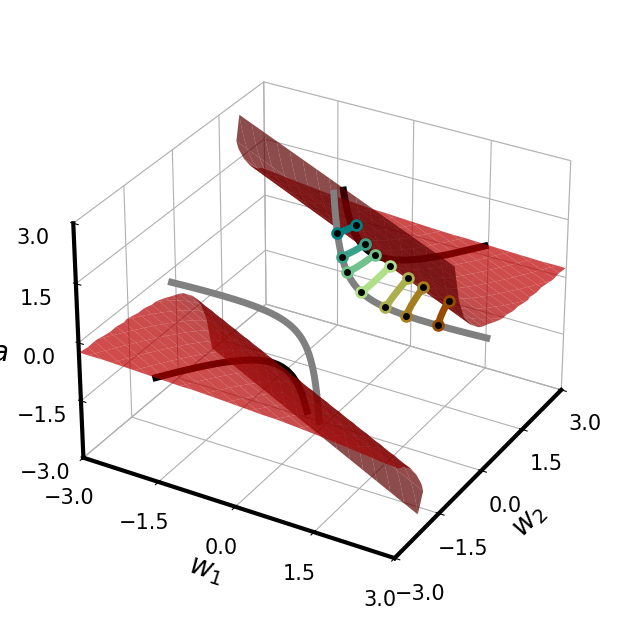

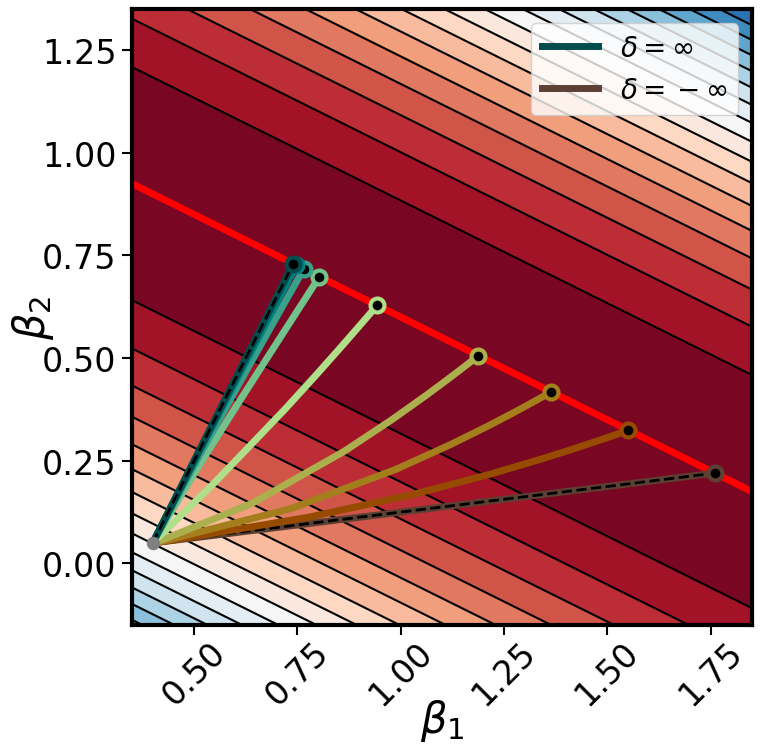

In [18]:
# Create 3D plot
fig1 = plt.figure(figsize=(8, 8))
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(111, projection='3d', computed_zorder=False)  # First subplot is a 3D plot
ax2 = fig2.add_subplot(111)  # Third subplot is a 2D plot

# Hyperparameters
lims = (-3, 3)
R_values = [-4, -2, -1, 0, 1, 2, 4] # a^2 - |w|^2

# Setup Data
X = np.array([0.5, 1])
XX = np.outer(X,X)
XY = 1.1 * X

# OLS solution
OLS = np.linalg.pinv(XX) @ XY

# Initialization
eps = 0.5
alpha = 0.6
beta0 = eps * (alpha * np.array([X[1], -X[0]]) + (1 - alpha) * X)
ax2.scatter(beta0[0], beta0[1], s=75, c='grey', zorder=5)

# Plot hyperbola of equivelent initializations
t = np.linspace(1e-5, 10, 1000)
plot_trimmed(ax1, beta0[0]/t, beta0[1]/t, t, lims, lw=5, color='grey', zorder=1)
plot_trimmed(ax1, -beta0[0]/t, -beta0[1]/t, -t, lims, lw=5, color='grey', zorder=-1)

# Plot hyperbola of equivelent min norm OLS solutions
a_opt = 1
w_opt = OLS
t = np.linspace(0.1, 10, 100)
plot_trimmed(ax1, w_opt[0]/t, w_opt[1]/t, a_opt*t, lims, lw=5, color='k', zorder=-1)
plot_trimmed(ax1, -w_opt[0]*t, -w_opt[1]*t, -a_opt/t, lims, lw=5, color='k', zorder=-1)

# Plot Function Space Surface
eps = 0.1
lim1 = np.array([0.25, 1.75])# np.array([min(OLS[0], beta0[0]) - eps, max(OLS[0], beta0[0]) + eps])
lim2 = np.array([-0.25, 1.25])# np.array([min(OLS[1], beta0[1]) - eps, max(OLS[1], beta0[1]) + eps])
plot_loss(ax2, lim1, lim2, XX, XY)
ax2.set_xlim(lim1[0] + eps, lim1[1] + eps)#ax2.set_xlim(1.1 * lim1)
ax2.set_ylim(lim2[0] + eps, lim2[1] + eps)#ax2.set_ylim(1.1 * lim2)

# Plot hyperbola sheet of OLS solutions
plot_minima_surface(ax1, OLS, lims, color="red", opacity=0.7)

# Null space
alpha = np.linspace(-2, 2, 100)
v = np.array([-OLS[1], OLS[0]])
plot_trimmed(ax2, OLS[0] + alpha*v[0], OLS[1] + alpha*v[1], None, [-4,4], lw=5, color='red', zorder=2)

# Plot \delta = -infty solution
tau = np.linalg.norm(OLS)**2 / np.dot(OLS, beta0)
ax2.plot([beta0[0], tau * beta0[0]], [beta0[1], tau * beta0[1]], label=r"$\delta = -\infty$", ls="-", lw=5, c='#5C4033')
ax2.plot([beta0[0], tau * beta0[0]], [beta0[1], tau * beta0[1]], ls="--", lw=2, c='k')
ax2.scatter(tau * beta0[0], tau * beta0[1], color='k', s=100, marker='o', zorder=4, edgecolor="#5C4033", linewidths=3)

for i, R in enumerate(R_values):

    # Get color
    c = get_diverging_colors_7(i) #cm.tab10(i)

    # Initialization
    w, a = coordinates(R, beta0)
    theta0 = np.concatenate((w, a))
    ax1.scatter(w[0], w[1], a, color='k', s=50, edgecolor=c, linewidths=2, zorder=3)

    # Gradient Flow
    T = 20
    grad = get_gradient(XX, XY)
    theta = solve_ivp(grad, [0, T], theta0, rtol=1e-6)
    time = theta.t
    w1_t = theta.y[0,:]
    w2_t = theta.y[1,:]
    a_t = theta.y[2,:]
    beta1 = a_t * w1_t
    beta2 = a_t * w2_t

    # Plot parameter and function space trajectories
    ax1.plot(w1_t, w2_t, a_t, color=c, lw=5, zorder=2)
    ax2.plot(beta1, beta2, color=c, lw=5)#, label=r'$\delta = {}$'.format(R))

    # Plot theoretical interpolating solution
    null = np.array([-OLS[1], OLS[0]]) / np.linalg.norm(OLS)
    alpha = implicit_bias_theory(R, beta0, OLS)
    optimal = OLS + alpha * null
    w_opt, a_opt = coordinates(R, optimal)
    ax1.scatter(w_opt[0], w_opt[1], a_opt, color='k', s=50, edgecolor=c, linewidths=2, zorder=3)
    ax2.scatter(optimal[0], optimal[1], color='k', s=100, marker='o', zorder=3, edgecolor=c, linewidths=3)#, label=r'$\delta = {}$'.format(R))

# Plot \delta = infty solution
minnorm_sol = OLS + beta0 - np.dot(beta0, OLS) / np.linalg.norm(OLS)**2 * OLS
ax2.plot([beta0[0], minnorm_sol[0]], [beta0[1], minnorm_sol[1]], label=r"$\delta = \infty$", ls="solid", lw=5, c='#014D4E', zorder=4)
ax2.plot([beta0[0], minnorm_sol[0]], [beta0[1], minnorm_sol[1]], ls="--", lw=2, c='k', zorder=4)
ax2.scatter(minnorm_sol[0], minnorm_sol[1], color='k', s=100, marker='o', zorder=4, edgecolor="#014D4E", linewidths=3)

# Style plots
style_3D(ax1, lims=lims, nofill=True)
ax1.set_xlabel(r"$w_1$", labelpad=15, fontsize=20)
ax1.set_ylabel(r"$w_2$", labelpad=15, fontsize=20)
ax1.set_zlabel(r"$a$", labelpad=15, fontsize=20)
ax1.set_box_aspect(aspect=None, zoom=0.9)
style_heatmaps(ax2)
ax2.set_xlabel(r"$\beta_1$", labelpad=-10, fontsize=30)
ax2.set_ylabel(r"$\beta_2$", labelpad=-10, fontsize=30)
ax2.legend(loc="best", fontsize=20, reverse=True)

# Show the plot
plt.show()

if not os.path.exists("null-space"):
    os.makedirs("null-space")
fig1.savefig('null-space/parameter-space.pdf', bbox_inches='tight')
fig2.savefig('null-space/function-space.pdf', bbox_inches='tight')

## Appendix A, Figure 8: Verifying that theory matches GD for single-neuron dynamics

R: -2, s: 0.7071067811865476, nu0: -1.2071067811865472, phi0: [0.45508986]
(2, 283) (283,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
R: -1, s: 0.7071067811865476, nu0: -0.8090169943749475, phi0: [0.78615138]
(2, 250) (250,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
R: -0.2, s: 0.7071067811865476, nu0: -0.5524937810560444, phi0: [2.12719012]
(2, 224) (224,)
--------------------------------------------------------------------------------
[0.95130834] -0.5255919429824074 0.7071067811865476
--------------------------------------------------------------------------------
R: 0.02, s: 0.7071067811865476, nu0: -0.49502499937503136, phi0: [7.10651109]
(2, 210) (210,)
--------------------------------------------------------------------------------
------------

/Users/allanraventos/miniconda3/envs/getrichquick/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/allanraventos/miniconda3/envs/getrichquick/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


R: -2, s: 0.7071067811865476, nu0: 0.0, phi0: [0.45508986]
(2, 257) (257,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
R: -1, s: 0.7071067811865476, nu0: 0.0, phi0: [0.78615138]
(2, 241) (241,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
R: -0.2, s: 0.7071067811865476, nu0: 0.0, phi0: [2.12719012]
(2, 195) (195,)
--------------------------------------------------------------------------------
[0.95130834] 0.0 0.7071067811865476
--------------------------------------------------------------------------------
R: 0.02, s: 0.7071067811865476, nu0: 0.0, phi0: [7.10651109]
(2, 189) (189,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
R: 0.2, s: 0

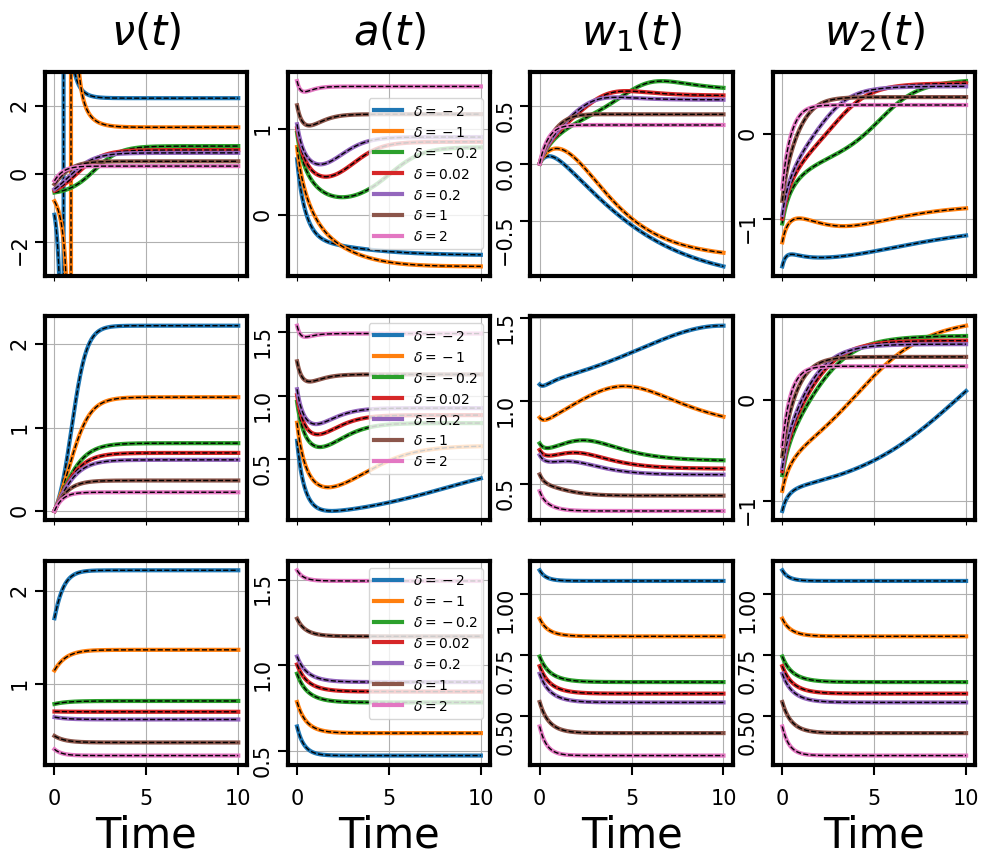

In [18]:
# Hyperparameters
# R_values = [-2, -1, 0, 1, 2]  # a^2 - |w|^2
R_values = [-2, -1, -0.2, 0.02, 0.2, 1, 2]    # avoiding 0 for time being

# Setup Data
XX = np.eye(2)

XY = np.array([0.5, 0.5])

# OLS solution
# (NOTE: this is the least-norm solution, but to be specific it is the only solution
# since we are taking X^TX to be full-rank, i.e. X to be full-rank)
OLS = np.linalg.pinv(XX) @ XY

beta0s = [np.array([0., -1.]), np.array([0.5, -0.5]), np.array([0.5, 0.5])]

n_quantities_plot = 4
fig, _axs = plt.subplots(len(beta0s), n_quantities_plot, figsize=(n_quantities_plot * 3, len(beta0s) * 3), sharex=True)

for _j, _beta0 in enumerate(beta0s):
    axs = _axs[_j]

    beta0 = _beta0 / np.linalg.norm(_beta0)

    i = 0
    for R in R_values:

        # Initialization (NOTE: this is always setting a to be positive, which will mean that
        # phi0 is always positive. Just note this because I think it simplifies things)
        w, a = coordinates(R, beta0)
        assert a > 0
        theta0 = np.concatenate((w, a))

        # Gradient Flow
        T = 10
        grad = get_gradient(XX, XY)
        theta = solve_ivp(grad, [0, T], theta0, atol=1e-11, rtol=1e-11)
        time = theta.t
        w1_t = theta.y[0, :]
        w2_t = theta.y[1, :]
        a_t = theta.y[2, :]

        # Can certainly blow up
        w_t = np.stack([w1_t, w2_t], axis=1)  # (n_timesteps, 2)
        # print(w_t[0, :], w)  # These do match
        nu = (w_t / a_t[:, None]) @ OLS
        if R > 0:
            theta = np.arctanh(np.linalg.norm(w_t, axis=1) / a_t)
            phi = np.cosh(theta)
        elif R < 0:
            theta = np.arctanh(a_t / np.linalg.norm(w_t, axis=1))
            phi = np.sinh(theta)

        # Compute using a and w since that's maybe a better test
        signed_beta_norm = a_t * np.linalg.norm(w_t, axis=1)
        mu = (w_t / np.linalg.norm(w_t, axis=1, keepdims=True)) @ OLS

        nu_theory, phi_theory, theta_theory, signed_beta_norm_theory, mu_theory = \
            theory(R, time, w, a, OLS)

        # Solve for w(t) and a(t)
        a_theory, w_norm_theory = a_w_norm(R, theta_theory)
        w_theory = get_w_theory(w, w_norm_theory, OLS, mu_theory, R, theta)

        # nu
        axs[0].plot(time, nu, lw=3, label=r'$\delta = {}$'.format(R))
        axs[0].plot(time, nu_theory, lw=1, ls='--', color='k')

        # # what we're now calling \varphi
        # axs[1].plot(time, theta, lw=3, label=r'$\delta = {}$'.format(R))
        # axs[1].plot(time, theta_theory, lw=1, ls='--', color='k')

        # # what we're now calling \zeta
        # axs[2].plot(time, phi, lw=3, label=r'$\delta = {}$'.format(R))
        # axs[2].plot(time, phi_theory, lw=1, ls='--', color='k')

        # print(f"phi[0]: {phi[0]}, nu[0]: {nu[0]}")
        print('-' * 80)
        if R == -0.2:
            print(a, (w * OLS).sum(), np.linalg.norm(OLS))
        print('-' * 80)

        # a
        axs[1].plot(time, a_t, lw=3, label=r'$\delta = {}$'.format(R))
        axs[1].plot(time, a_theory, lw=1, ls='--', color='k')

        # w1 and w2
        axs[2].plot(time, w_t[:, 0], lw=3)
        axs[2].plot(time, w_theory[:, 0], lw=1, ls='--', color='k')
        axs[3].plot(time, w_t[:, 1], lw=3)
        axs[3].plot(time, w_theory[:, 1], lw=1, ls='--', color='k')

    if _j == len(beta0s) - 1:
        for ax in axs:
            ax.set_xlabel("Time", fontsize=30)

    for ax in axs:
        ax.grid()
    axs[1].legend()

    if _j == 0:
        axs[0].set_title("$\\nu(t)$", fontsize=30, pad=20)
        # axs[1].set_title("$\\varphi(t)$", fontsize=35)
        # axs[2].set_title("$\zeta(t)$", fontsize=35)
        axs[1].set_title("$a(t)$", fontsize=30, pad=20)
        axs[2].set_title("$w_1(t)$", fontsize=30, pad=20)
        axs[3].set_title("$w_2(t)$", fontsize=30, pad=20)

    if _j == 0:
        _axs[0, 0].set_ylim(-3, 3)

for _row in range(len(_axs)):
    for _col in range(len(_axs[0])):
        ax = _axs[_row, _col]
        for dir in ["top", "bottom", "right", "left"]:
            ax.spines[dir].set_linewidth(3)
            if _row == len(_axs) - 1:
                ax.tick_params(axis="x", which="both", bottom=True, top=False,
                    labelbottom=True, left=True, right=False,
                    labelleft=True, direction='out',length=7,width=1.5,pad=10,
                    labelsize=15,labelrotation=0)
            ax.tick_params(axis="y", which="both", bottom=True, top=False,
                        labelbottom=True, left=True, right=False,
                        labelleft=True, direction='out',length=7,width=1.5,pad=4,
                        labelsize=15, labelrotation=90)

plt.savefig("params.pdf", bbox_inches="tight")

## Appendix A, Figure 7: Basins of attraction

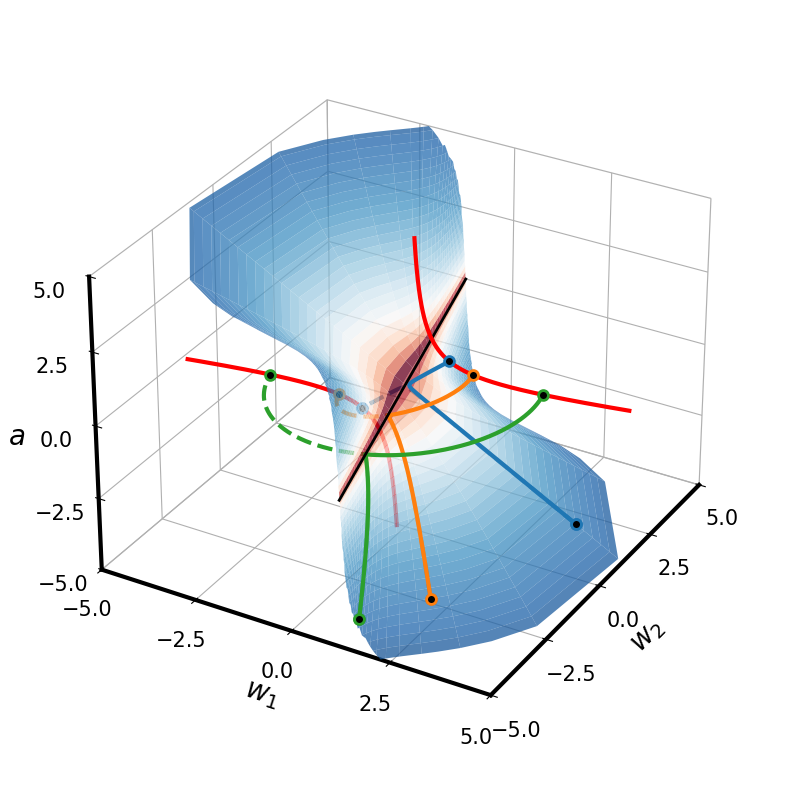

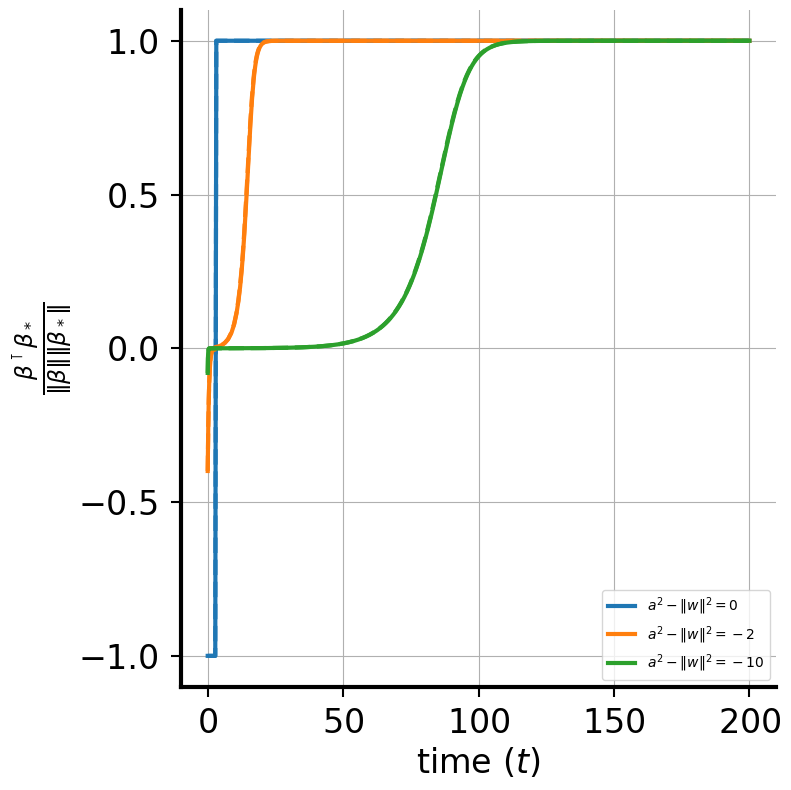

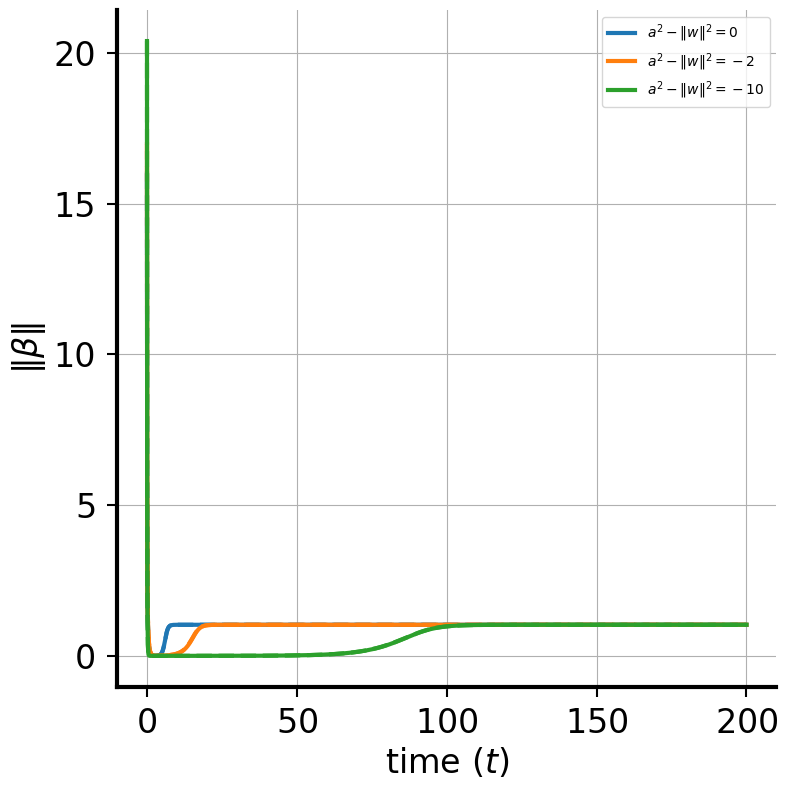

In [19]:
# Create figures
fig1 = plt.figure(figsize=(8, 8))
fig2 = plt.figure(figsize=(8, 8))
fig3 = plt.figure(figsize=(8, 8))

# Create axes
ax1 = fig1.add_subplot(111, projection='3d', computed_zorder=False)  # First plot is a 3D plot
ax2 = fig2.add_subplot(111)  # Third subplot is a 2D plot
ax3 = fig3.add_subplot(111)  # Third subplot is a 2D plot

# Setup Data
XX = np.eye(2)
XY = np.array([1, 0.25])

# OLS solution
OLS = np.linalg.pinv(XX) @ XY

# Seperating Surface
lims = (-5, 5)
# lim1, lim2 = 40, 5
plot_basin_seperating_surface(ax1, lims, XX, XY, opacity=0.75)

# Plot hyperbola of equivelent OLS solutions
w_opt, a_opt = coordinates(0, OLS)
t = np.linspace(1, 10, 1000)
plot_trimmed(ax1, w_opt[0]/t, w_opt[1]/t, a_opt*t, lims, lw=3, color='red', zorder=100)
plot_trimmed(ax1, w_opt[0]*t, w_opt[1]*t, a_opt/t, lims, lw=3, color='red', zorder=100)
plot_trimmed(ax1, -w_opt[0]*t, -w_opt[1]*t, -a_opt/t, lims, lw=3, color='red', zorder=-100)
plot_trimmed(ax1, -w_opt[0]/t, -w_opt[1]/t, -a_opt*t, lims, lw=3, color='red', zorder=-100)

t = np.linspace(-10, 10, 1000)
plot_trimmed(ax1, -OLS[1]*t, OLS[0]*t, np.zeros_like(t), lims, lw=2, color='k', zorder=90)

deltas = [0, -2, -10]
epsilon = [1e-3, -1e-3]

for i, delta in enumerate(deltas):
    for j, eps in enumerate(epsilon):
        # Initialization on the seperating surface (can do by choosing w instead)
        alpha = -4
        k = alpha * (-delta / 2 - np.sqrt(delta**2 + 4 * np.linalg.norm(OLS)**2) / 2)
        a = OLS[0]**2 / OLS[1]**2 + 1
        b = -2*k*OLS[0]/OLS[1]**2
        c = k**2 / OLS[1]**2 + delta - alpha**2
        w1 = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
        w2 = (k - OLS[0]*w1) / OLS[1]
        a = alpha

        w, a = np.array([w1, w2]), np.array([a + eps])
        theta0 = np.concatenate((w, a))
        ax1.scatter(w[0], w[1], a, color='k', s=50, edgecolor=cm.tab10(i), linewidths=2, zorder=2 * np.sign(eps))

        # Gradient Flow
        T = 200
        grad = get_gradient(XX, XY)
        theta = solve_ivp(grad, [0, T], theta0, rtol=1e-6)
        time = theta.t
        w1_t = theta.y[0,:]
        w2_t = theta.y[1,:]
        a_t = theta.y[2,:]
        beta1 = a_t * w1_t
        beta2 = a_t * w2_t
        norm = np.sqrt(beta1**2 + beta2**2)
        mu = (OLS[0]*beta1 + OLS[1]*beta2) / (norm * np.linalg.norm(OLS))

        # Plot parameter and function space trajectories
        if eps > 0:
            ax1.plot(w1_t, w2_t, a_t, color=cm.tab10(i), lw=3, ls='-', label=r'$a^2 - \|w\|^2 = {}$'.format(delta), zorder=1)
            ax2.plot(time, mu, color=cm.tab10(i), lw=3, ls='-', label=r'$a^2 - \|w\|^2 = {}$'.format(delta))
            ax3.plot(time, norm, color=cm.tab10(i), lw=3, ls='-', label=r'$a^2 - \|w\|^2 = {}$'.format(delta))
        else:
            ax1.plot(w1_t, w2_t, a_t, color=cm.tab10(i), lw=3, ls='--', zorder=-1)
            ax2.plot(time, mu, color=cm.tab10(i), lw=3, ls='--')
            ax3.plot(time, norm, color=cm.tab10(i), lw=3, ls='--')

        # Plot final solution
        zorder = 200 if np.sign(eps) > 0 else -1
        ax1.scatter(w1_t[-1], w2_t[-1], a_t[-1], color='k', s=50, edgecolor=cm.tab10(i), linewidths=2, zorder=zorder)

# Show the plot
style_3D(ax1, lims=lims, nofill=True)
ax1.set_xlabel(r"$w_1$", labelpad=15, fontsize=20)
ax1.set_ylabel(r"$w_2$", labelpad=15, fontsize=20)
ax1.set_zlabel(r"$a$", labelpad=15, fontsize=20)
ax1.set_box_aspect(aspect=None, zoom=0.9)

style_axes(ax2)
ax2.set_xlabel(r"time ($t$)", fontsize=24)
ax2.set_ylabel(r"$\frac{\beta^\intercal \beta_*}{\|\beta\|\|\beta_*\|}$", fontsize=24)
ax2.legend(loc="best")

style_axes(ax3)
ax3.set_xlabel(r"time ($t$)", fontsize=24)
ax3.set_ylabel(r"$\|\beta\|$", fontsize=24)
ax3.legend(loc="best")

fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
plt.show()

# Save figure
if not os.path.exists("basins"):
    os.makedirs("basins")
fig1.savefig('basins/seperating-surface.pdf')
fig2.savefig('basins/alignment.pdf')
fig3.savefig('basins/norm.pdf')